In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import json
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress

from helpers.expr_data2 import ExprData2
from helpers.scale_data import ScaleData
from helpers.similarity import Similarity
from helpers.feature_selection import FeatureSelection

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(47907)
random.seed(15213)

In [4]:
xml_wl_cpus = ['ter5', 'terx', 'tery']
candid = 'tery'

In [5]:
'''
Generate scatter plot by similarity
Attributes:
    simi_mtxs : list of simi_mtxs or simi_col_mtxs using different number of features
    simi_data : should be same for all simi_mtxs
    feature_groups: labels of the feature group: top3, top7, plan, resource, all
    root_idx: the i-th experiment as the base run, will plot pairwise distance between the base run and other runs
    method_type: Type of method used to calculate similarity
    colwise: True if the calculation is columnwised, False if not
'''
def plot_scores_diff_feature_num(simi_mtxs, simi_data, feature_groups, root_idx, method_type, colwise=False, note=''):
    fig, ax = plt.subplots(figsize=(3*len(feature_groups), 2.8))
    zipped = []
    for simi_mtx, feature_group in zip(simi_mtxs, feature_groups):       
        curr_zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, [feature_group]*simi_data.get_num_exprs(), simi_mtx[root_idx]))
        del curr_zipped[root_idx]
        zipped += curr_zipped
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','feature_group', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)

    order=['tpcc', 'tpch', 'twitter']
    if X_p['workload'].nunique() == 4:
        order.append('tpcds')
    
    sns.barplot(y="distance", x="feature_group", hue_order=order,
                hue="workload", data=X_p, ax=ax, 
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    plt.xlabel('')
    plt.ylabel('Normalized Distance')
    
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 
    cpu_num_val = simi_data.cpu_nums[root_idx]
    if colwise:
        colwise_label = 'Independent'
    else:
        colwise_label = 'Dependent'
    title = 'Base Workload: {}, Method: {} {}.{}'.format(
        wl_name, cpu_num_val, colwise_label, method_type, note)
    fname = '{}{}_cpu{}_{}_{}{}.pdf'.format(wl_name, expr_idx, cpu_num_val, colwise_label, method_type, note)
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=4, mode="expand")
    print(title)
    plt.savefig(f'figs/new_wmc_{fname}', bbox_inches = 'tight')
    plt.show()

In [6]:
def plot_scores_single(simi_mtx, simi_data, root_idx, data_type, method_type, note=''):
    fig, ax = plt.subplots(figsize=(4.8,2))

    zipped = list(zip(simi_data.wl_groups, simi_data.wl_names, simi_data.cpu_nums, simi_mtx[root_idx]))
    X_p = pd.DataFrame(zipped, columns=['run', 'workload','cpu_num', 'distance'])
    X_p = X_p.astype({'distance': float})
    X_p.drop([root_idx],inplace=True)
    
    order=['tpcc', 'tpch', 'twitter']
    if X_p['workload'].nunique() == 4:
        order.append('tpcds')

    sns.barplot(y="distance", x="workload", order=order,
                data=X_p, ax=ax, errorbar="sd",
                palette=sns.color_palette()[:X_p['workload'].nunique()])
    ax.set_xlabel('')
    expr_idx = simi_data.wl_groups[root_idx]
    wl_name = simi_data.wl_names[root_idx] 

    plt.savefig(f'figs/Test_Single_{candid}_2', bbox_inches = 'tight')
    plt.show()

In [7]:
data = ExprData2()
data.load_pickle(exclude_cpu=[ter for ter in xml_wl_cpus if ter != candid ])
candid_idx = data.cpu_nums.index(candid)

In [8]:
# similarity for all
scaler = ScaleData()
plan_mtxs, plan_col_ranges = scaler.scale(data.plan_mtxs)

simi_calc_all = Similarity(data, plan_mtxs, plan_col_ranges, None, [])
simi_calc_all.calc_bined_mtx(plan_only=True) # all plan features

In [9]:
simi_calc = simi_calc_all
fs = FeatureSelection(simi_calc)
plan_features = data.plan_feature_cols
plan_top_7 = fs.select_features(7, 'MutualInfoGain', est_name=None, direction=None, feature_type='plan')
plan_top_3 = fs.select_features(3, 'MutualInfoGain', est_name=None, direction=None, feature_type='plan')
print(plan_top_7)
feature_group_plan = ['plan_3', 'plan_7', 'plan']
features_plan = [plan_top_3, plan_top_7, plan_features]

(18, 18, 22)
(18, 18, 22)
['EstimateIO', 'AvgRowSize', 'CompileMemory', 'SerialRequiredMemory', 'EstimateRows', 'CachedPlanSize', 'StatementSubTreeCost']


In [10]:
simi_mtxs = []
for feature_group in features_plan:
    simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=feature_group, norm_type='canb')#, normalize=False)
    simi_mtxs.append(simi_calc.simi_mtx)

Base Workload: xml, Method: tery Independent.Cumulative Histogram Canb Norm


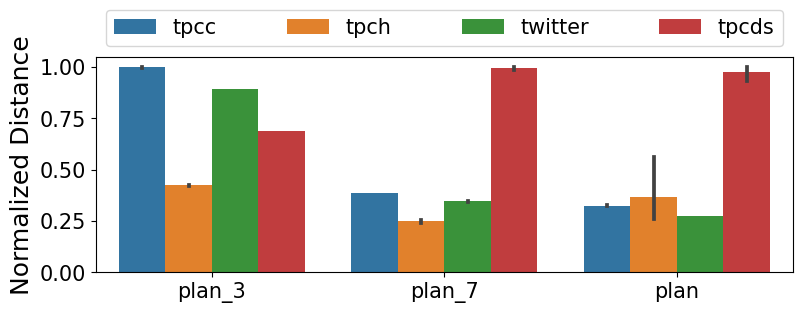

In [11]:
plot_scores_diff_feature_num(simi_mtxs, simi_calc.data, feature_group_plan, candid_idx, 'Cumulative Histogram Canb Norm', colwise=True, note='')

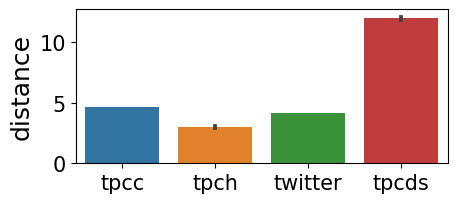

In [12]:
simi_calc.calc_dist_simi_matrix(cumulative=True, feature_names=plan_top_7, norm_type='canb', normalize=False)

assert(simi_calc.data.wl_names[candid_idx] == 'xml')
plot_scores_single(simi_calc.simi_mtx, simi_calc.data, candid_idx, 'Top7 Plan', 'Cumulative Histogram Canb Norm', note='')